<div style="border: 1px solid #CCCCFF; border-radius: 1px;">
<div style="margin: 5px">
<b class="alert-heading">Комментарий ревьюера</b>
<p>Кирилл, привет!</p>
<p>Меня зовут Алексей Секоцкий. Поздравляю с подготовкой очередного проекта. Предлагаю обращаться друг к другу на «ты» если нет возражений. Ниже стандартный блок с условными обозначениями:</p>
<div class="alert alert-success" role="alert">
всё отлично
</div>
<div class="alert alert-warning" role="alert">
рекомендации на будущее (не требующие доработки проекта)
</div>
<div class="alert alert-danger" role="alert">
критичные моменты требующие внимания (доработки)
</div>
<div class="alert alert-info">
итоговый комментарий
</div>

<hr>
<p>Пожалуйста, не изменяй и не удаляй мои комментарии – они потребуются для повторной проверки (при необходимости). Задавай вопросы и описывай сделанные изменения, помечая их любым удобным наглядным способом.</p>

**Комментарий студента:** 
Безумно приятно читать такие ревью, спасибо;)

<div class="alert alert-warning" role="alert">
    <b>Исправлено</b>
    
Исправил разбиение на выборки, добавил валидацонную, также изменились метрики
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Спасибо за быстроту! Супер!
</div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Необходимо построить модель для такого предсказания. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План работы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Описание данных

Данные лежат в файле /datasets/taxi.csv

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
import os
import urllib.request

import sklearn
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

STATE=42

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Создадим папку если ее нет
Path('datasets').mkdir(parents=True, exist_ok=True)
# Словарь с именем файла и ссылкой на него
urls = {
    'taxi' : ('https://code.s3.yandex.net/datasets/taxi.csv' , '/datasets/taxi.csv')    
}

# Проверим есть ли файл
if not os.path.exists(urls.get('taxi')[1]):
    print(urls.get('taxi')[1], 'файл не найден, будет скачан из сети')
    # качаем файл по ссылке url, кладем по пути file_name
    urllib.request.urlretrieve(*urls.get('taxi'))
    
df = pd.read_csv(urls['taxi'][1], parse_dates=[0], index_col=[0])

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# Посмотрим на наш целевой признак
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
# Отсортируем признак и проверим на монотонность
df.sort_index(inplace=True)
df.index.is_monotonic

True

**Вывод**

- Сделали выгрузку датасета, поменяли тип данных временного признака с object на datetime64, а также установили его индексом всего датафрейма;
- Отсортировали датафрейм по индексу, а также проверили наш временной ряд на монотонность;
- Общее количество заказов за все предоставленное время - 26496, в среднем у нас 14 заказов, среднее отклонение - 9, а максимальное количество заказов в час - 119.

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Отлично. Данные загружены.
</div>

## Анализ

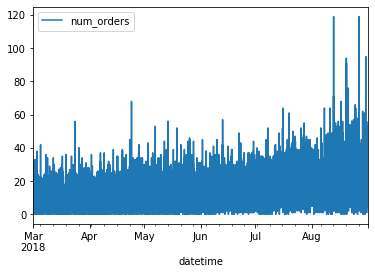

In [7]:
# Посмотрим на наш временной ряд в том виде в котором он у нас есть сейчас
df.plot(ax=plt.gca())
plt.show()

In [8]:
# Ресемплируем выборку и вычислим сумму сгруппированных значений за каждый час
df = df.resample('1H').sum()

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Отлично, что ресемплирование по сумме.    
</div>

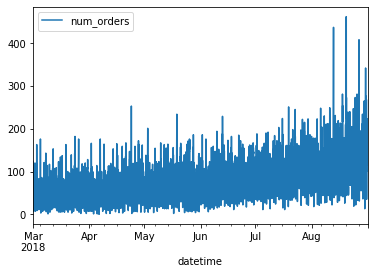

In [9]:
# Снова посмотрим на наш временной ряд после ресемплирования
df.plot(ax=plt.gca())
plt.show()

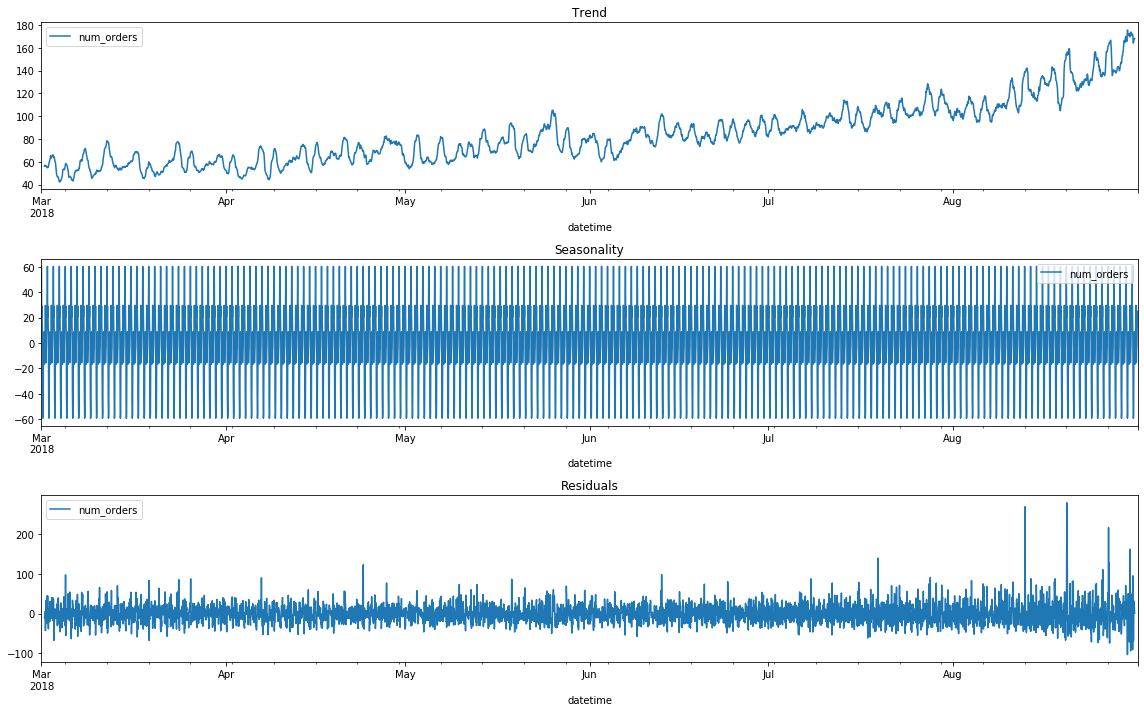

In [10]:
# Разложим временной ряд на тренд и сезонность
decomposed = seasonal_decompose(df)
plt.figure(figsize=(16, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

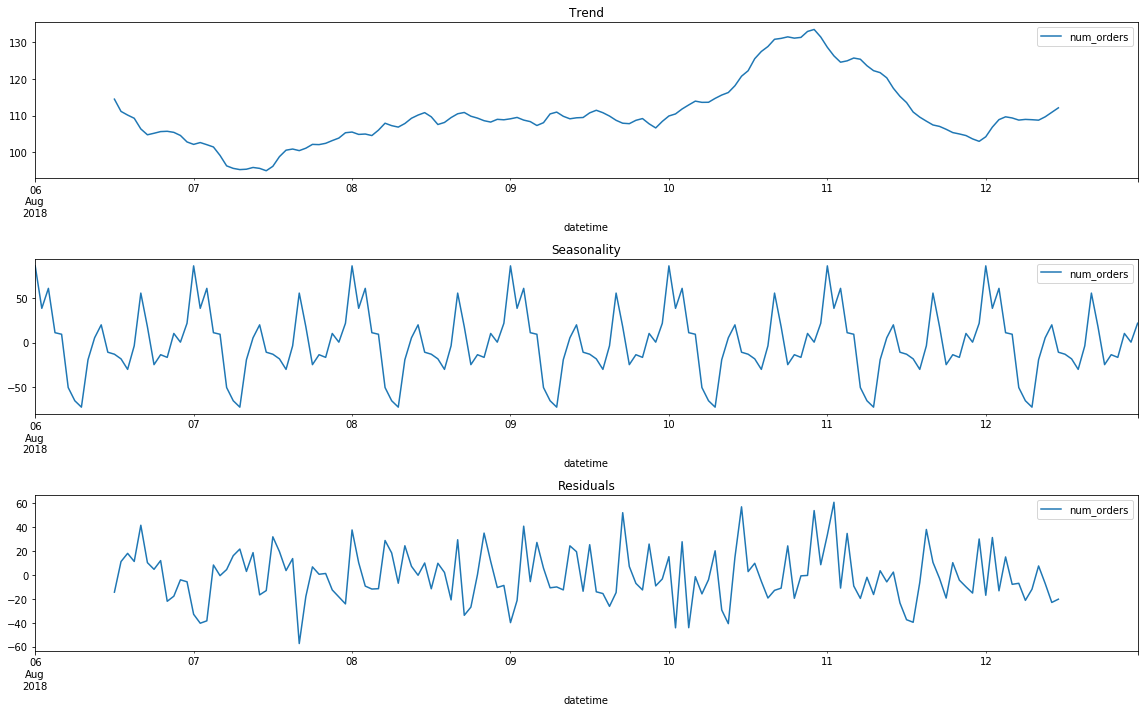

In [11]:
# Посмотрим более детально на сезонность первой полной недели Августа
df_aug = df['2018-08-06':'2018-08-12']
decomposed = seasonal_decompose(df_aug)
plt.figure(figsize=(16,10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Отлично, что взят более короткий период для детального анализа!
</div>

<Figure size 1152x720 with 0 Axes>

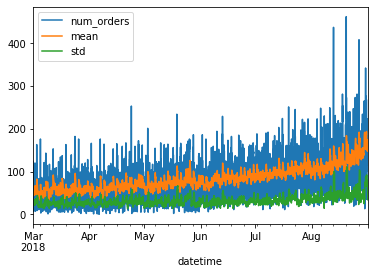

In [12]:
# Посмотрим на стационарность нашего ряда и при необходимости будем работать с разностью временного ряда
df['mean'] = df['num_orders'].rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
plt.figure(figsize=(16,10))
df.plot()
plt.show()

In [13]:
df.drop(['mean', 'std'], axis=1, inplace=True)

**Комментарий ревьюеру:** Насколько нам вообще важно(в целом, не только в этом проекте) работать с более стационарным рядом или же нам просто важен сам факт стационарности?

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Мы определяем стационарный у нас процесс или нет чтобы затем принимать решения по работе с рядом. Например, если у нас только выраженный тренд (без сезонности и случайного блуждания), то путем преобразований можно будет смоделировать стационарый временной ряд. Мы в задаче делая декомпозицию выделяем отдельно тренд, отдельно сезонность и шум. Стационарный ряд - это «очищенный» ряд от всех трех компонентов. Нужно это для построения моделей, напирмер, ARIMA. В нашем случае мы прогнозируем ряд регрессией, поэтому можно не использовать данное понятие.
</div>

<div class="alert alert-warning" role="alert">
    <b>Комментарий студента</b>
    
Суть стационарности ясна, вопрос скорее в том важно ли нам работать с БОЛЕЕ стационарным рядом? Например наш дефолтный в этом проекте ряд уже стцаионарен, но я могу его прологарифмировать для получения БОЛЕЕ стационарного, но надо ли оно нам или же просто самого факта, что у нас стационарный ряд уже достаточно?)    
    
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

В нашем случае, работая с регрессией, ненужно.
</div>

**Вывод**

- Мы видим явный тренд на увеличение количества заказов такси к концу августа, как вариант это может быть связано с началом учебного времени, а также окончанием отпускного сезона;
- Также прослеживается суточная сезонность: больше заказов к коцну дня;
- Наш временной ряд стационарен.

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Верный вывод.
</div>

## Обучение

**Создание обучающего и тестового набора данных**

In [14]:
# напишем функцию создания признаков
def make_features(data, max_lag, rolling_mean_size):
    '''
    data - датафрейм
    max_lag - максимальный размер отставания
    rolling_mean_size - ширина окна
    '''
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Отлично, что выбраны признаки `'hour'` и `'dayofweek'`, однако, желательно обосновать данный выбор. Почему не выбраны признаки года, месяца и дня месяца – это тоже желательно описать.<br>
</div>

In [15]:
make_features(df,24,3)
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.333333
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.000000


<div class="alert alert-warning">
<b>Комментарий ревьюера</b>

Выбор параметров лага и скользящего среднего желательно обосновать.
</div>

In [16]:
# разобьем данные на обучающую, валидационную и тестовую, и выведим их размерности
train, test = train_test_split(df, shuffle=False, test_size=0.2)
valid, test = train_test_split(test, shuffle=False, test_size=0.5)
print(f'train: {train.index.min(), train.index.max()}')
print(f'valid: {valid.index.min(), valid.index.max()}')
print(f'test: {test.index.min(), test.index.max()}')

train: (Timestamp('2018-03-01 00:00:00'), Timestamp('2018-07-26 03:00:00'))
valid: (Timestamp('2018-07-26 04:00:00'), Timestamp('2018-08-13 13:00:00'))
test: (Timestamp('2018-08-13 14:00:00'), Timestamp('2018-08-31 23:00:00'))


<s><div class="alert alert-danger">
<b>Комментарий ревьюера</b>

Почему идет разделение только на 2 выборки? Как будут подбираться гиперпараметры?    
<br/>

In [17]:
# дропнем все строки с пропусками из обучающей выборки
train.dropna(inplace=True)
train.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,79.000000
2018-03-02 01:00:00,120,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,87.000000
2018-03-02 02:00:00,75,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,89.333333
2018-03-02 03:00:00,64,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,95.000000
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,86.333333


In [18]:
# выделим целевой признак в выборках 
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

**Линейная регрессия**

In [19]:
# обучим модель линейной регрессии
LR = LinearRegression()
LR.fit(features_train, target_train)
LR_pred = LR.predict(features_valid)
# предскажем значения нашей метрики на модели
print('RMSE на валидационной выборке {:.2f} '.format(np.sqrt(mean_squared_error(LR_pred, target_valid))))

RMSE на валидационной выборке 34.31 


<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Отлично, однако, размер валидационной выборки можно было немного увеличить.
</div>

<s><div class="alert alert-danger">
<b>Комментарий ревьюера</b>

Предсказания на выборке на которой обучалась модель? Если используются всего 2 выборки, то на одной учим, а на другой тестируем.
<br/>

**Случайный лес**

In [20]:
%%time
# проведем подбор гиперпараметров для модели случайного леса
params = {'n_estimators': [20, 100, 400],
          'max_depth': [10, 50, 100],
          'min_samples_split': [2, 5, 10]}

RF = RandomForestRegressor(random_state = STATE)

best_score = 48
for param in ParameterGrid(params):
    RF.set_params(**param)
    RF.fit(features_train, target_train)
    RF_pred = RF.predict(features_valid)
    RMSE_current = np.sqrt(mean_squared_error(RF_pred, target_valid))
    if RMSE_current < best_score:
        best_score = RMSE_current
        best_params = param

print('RMSE {:.2f} '.format(best_score))
print('Гиперпараметры:', best_params)

RMSE 32.34 
Гиперпараметры: {'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 400}
CPU times: user 3min 47s, sys: 332 ms, total: 3min 47s
Wall time: 3min 52s


<s><div class="alert alert-danger">
<b>Комментарий ревьюера</b>

Если мы не используем кросс-валидацию (примечание: для временных рядов есть особенности ее применения), то мы должны использовать валидационную выборку для подбора гиперпараметров. Метрика RMSE 8.55 – это космический результат, такой может быть только при переобучении.
<br/>

In [21]:
# обучим модель с найденными гиперпараметрами
RF_best = RandomForestRegressor(max_depth = 50, min_samples_split = 5, n_estimators = 400, random_state = STATE)
RF_best.fit(features_train, target_train)
RF_pred = RF_best.predict(features_valid)
print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(RF_pred, target_valid))))

RMSE: 32.41


## Тестирование

**Метрика RMSE на тестовой выборке**

In [22]:
# Значение модели линейной модели на тестовой выборке
LR_pred = LR.predict(features_test)
print('RMSE на тестовой выборке {:.2f} '.format(np.sqrt(mean_squared_error(LR_pred, target_test))))

RMSE на тестовой выборке 45.62 


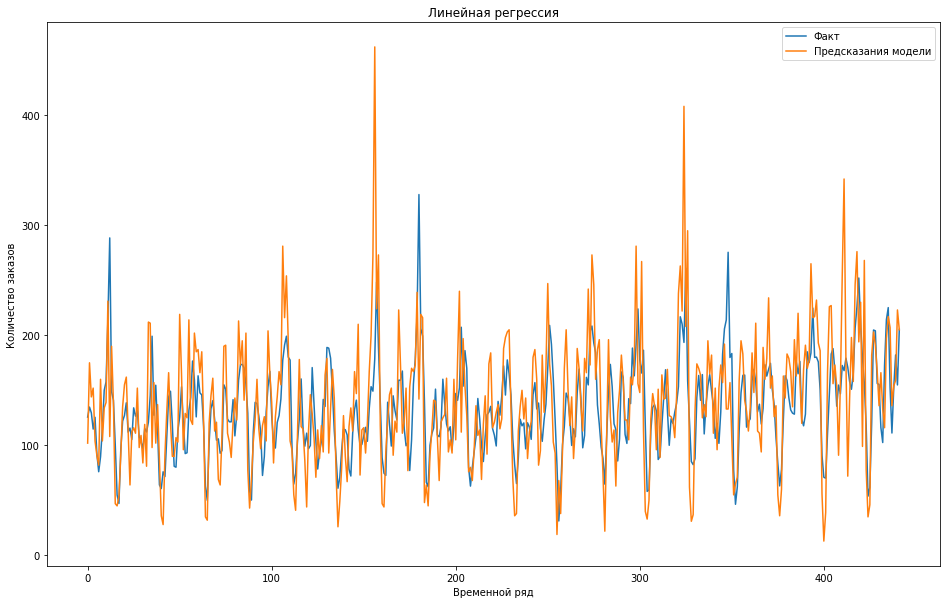

In [23]:
plt.figure(figsize=(16,10))
plt.plot(LR_pred)
plt.plot(np.array(target_test))
plt.legend(['Факт', 'Предсказания модели'])
plt.title('Линейная регрессия')
plt.xlabel('Временной ряд')
plt.ylabel('Количество заказов')
plt.show()

In [24]:
# Значение модели линейной модели на тестовой выборке
RF_pred = RF_best.predict(features_test)
print('RMSE модели случайный лес на тестовой выборке: {:.2f}'.format(np.sqrt(mean_squared_error(RF_pred, target_test))))

RMSE модели случайный лес на тестовой выборке: 50.06


<s><div class="alert alert-success">
<b>Комментарий ревьюера</b>

Такая метрика удовлетворяет заданию.    
</div>

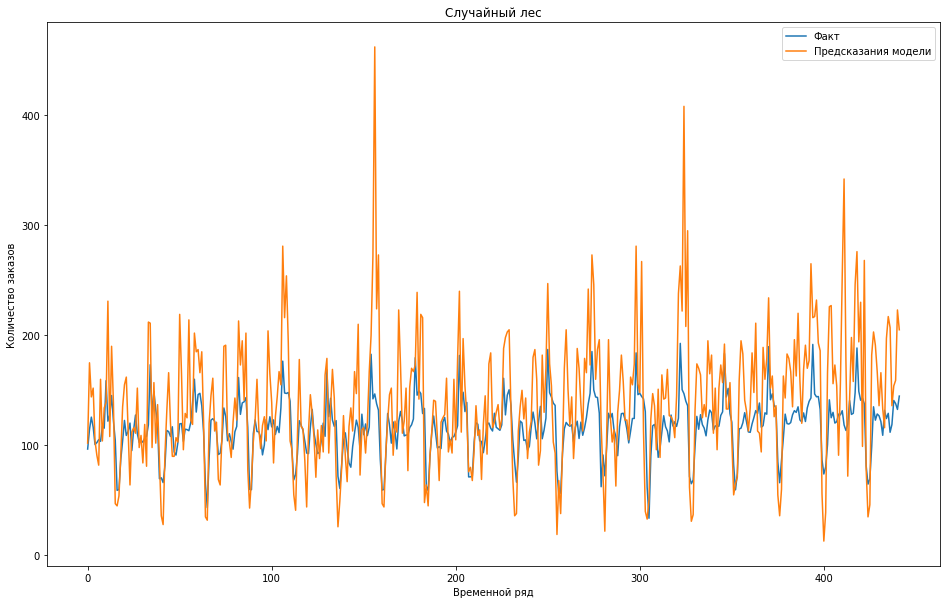

In [25]:
plt.figure(figsize=(16,10))
plt.plot(RF_pred)
plt.plot(np.array(target_test))
plt.legend(['Факт', 'Предсказания модели'])
plt.title('Случайный лес')
plt.xlabel('Временной ряд')
plt.ylabel('Количество заказов')
plt.show()

**Проверка адекватности модели**

In [26]:
# Напишем стандатную модель предсказания по предыдущим значениям
default_pred = target_test.shift(fill_value=target_train.iloc[-1])
print('RMSE стандартной модели по прошлым значениям: {:.2f}'.format(np.sqrt(mean_squared_error(default_pred, target_test))))

RMSE стандартной модели по прошлым значениям: 58.88


## Вывод

- Сделали выгрузку датасета, поменяли тип данных временного признака с object на datetime64, а также установили его индексом всего датафрейма;
- Отсортировали датафрейм по индексу, а также проверили наш временной ряд на монотонность;
- Общее количество заказов за все предоставленное время - 26496, в среднем у нас 14 заказов, среднее отклонение - 9, а максимальное количество заказов в час - 119.
- Увидили явный тренд на увеличение количества заказов такси к концу августа, а также суточную сезонность c пиком в конце дня;
- Обучили модели линейной регрессии и случайного леса на обучающей выборке, а так же протестировали их на на тестовых. Получили значения метрики RMSE 45.62 и 50.06 соответственно;
- Сравнили значения полученные нашими моделями со значением метрики RMSE стандартной модели построенной на прошлых значениях;

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Очень хороший проект. Видно понимание темы. Необходимо уточнить разбиение на выборки и обучение моделей. Буду ждать новую версию.
</div>

<div class="alert alert-info">
<b>Итоговый комментарий ревьюера</b>

Поздравляю с успешным прохождением важного спринта. Тема временных рядов достаточно широкая и уместить ее в один спринт невозможно, однако, показанное понимание основ должно позволить в будущем изучить ее более детально (при необходимости). Желаю успехов в дальнейшей учебе!
<hr>
</div>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48